##  Car Price Prediction - Preprocessing

###  Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import re
import pprint
import joblib

#Python iterators for efficient looping
import itertools

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### Import Raw Data

In [2]:
#Import data - austin, dallas, houston, and san antonio.  Two snapshots.

austin1=pd.read_json('json/austin_ford_2019-11-18.json')
dallas1=pd.read_json('json/dallas_ford_2019-11-18.json')
ep1=pd.read_json('json/ep_ford_2019-11-18.json')
houston1=pd.read_json('json/houston_ford_2019-11-18.json')
sa1=pd.read_json('json/sa_ford_2019_11_18.json')

austin2=pd.read_json('json/austin_ford_2019-12-29.json')
dallas2=pd.read_json('json/dallas_ford_2019-12-29.json')
ep2=pd.read_json('json/ep_ford_2019-12-29.json')
houston2=pd.read_json('json/houston_ford_2019-12-29.json')
sa2=pd.read_json('json/sa_ford_2019_11_18.json')

vehicle = pd.DataFrame()
for dframe in [austin1, dallas1, ep1, houston1, sa1, austin2, dallas2, ep2, houston2, sa2]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display(f'vehicle has {len(vehicle)} rows:', vehicle.tail(1))

'vehicle has 21080 rows:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
21079,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW ...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...


In [3]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace NaNs with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [4]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))

vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(1)

vehicle length: 21080
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...


In [5]:
def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.  Case is ignored.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.')
    return matchList
    
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.
In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.


In [6]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083


In [7]:
vehicle['AttribDictionary']

0        {'0': '<span><b>2016 FORD</b></span>', '1': '<...
1        {'0': '<span><b>2006 Ford Focus SE</b></span>'...
2        {'0': '<span><b>2004 FORD F450</b></span>', '1...
3        {'0': '<span><b>2007 FORD E350 SHUTTLE BUS</b>...
4        {'0': '<span><b>1979 1979 FORD MUSTANG</b></sp...
                               ...                        
21075    {'0': '<span><b>2013 Ford Explorer SUV</b></sp...
21076    {'0': '<span><b>2005 FORD E350</b></span>', '1...
21077    {'0': '<span><b>2014 Ford Mustang</b></span>',...
21078    {'0': '<span><b>2016 FORD</b></span>', '1': '<...
21079    {'0': '<span><b>2008 ford f-250 super duty cre...
Name: AttribDictionary, Length: 21080, dtype: object

In [8]:
#Drop incomplete listing 5247.
vehicle.drop(index = 5247, inplace = True)

In [9]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1995 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1995)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 1323


In [10]:
#Extract Odometer & VIN from AttribDictionary.  For each index, go through dict keys.
odomet=[]
vin = []
vinCNT=0

for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        #cond_m = re.search(r'<span>condition: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))          
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Assign unique value.  VIN is missing, not neccesarily duplicate listing.


vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

In [11]:
#Create final Odometer feature

#Mine Odometer alternative from Body.
odomAlt=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAlt, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

In Body, 12530 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).


In [12]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [13]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,NaN,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,NaN,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2


In [14]:
#Extract RawMake col from AttribDictionary.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [15]:
vehicle.tail(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
21078,https://sanantonio.craigslist.org/ctd/d/temple...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",sanantonio,2016,NaN,127.0,2016 ford,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706808,None9349
21079,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,sanantonio,2008,NaN,134000.0,2008 ford f-250 super duty crew cab,NaN,NaN,NaN,dealer,$16900,(1200 basse rd San Antonio TX),"\n ,\n2008 FORD F250 SUPER DUTY CREW CA...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...,7022667038,None9350


In [16]:
#Populate Make
make_regex=r'(ford)\s'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.  Search for ford + space + word + optional hyphen + NonWhiteSpace
model_regex=r'ford\s(\w+-{0,1}\S+)'
modelList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = modelList

#Populate Trim.  Search for ford + space + word + optional hyphen + NonWhiteSpace + space + word
trim_regex=r'ford\s\w+-{0,1}\S+\s(\w+)'
trimList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=trim_regex, no_match_value='None')    
vehicle['Trim'] = trimList

#FIX scenario1: 'ford super duty myModel' issue.  Model 'super' is wrong.
model_regex2=r'ford\s\w+\s\w+\s(\w+-{0,1}\S+)'  #get word after 'ford super duty'
model_for_super_1st = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex2, no_match_value='None')
vehicle['Modelfix']=model_for_super_1st  #Use Modelfix for scenario1 vehicles only.

#Correct Trim and Model.  Drop 'Modelfix' column.
vehicle.loc[vehicle['Model'] == 'super', 'Trim'] = 'super'
vehicle.loc[vehicle['Model'] == 'super', 'Model'] = vehicle.loc[vehicle['Model'] == 'super', 'Modelfix']
vehicle.drop(['Modelfix'], axis='columns', inplace = True, errors = 'ignore')

In RawMake, 202 missed matches for regex pattern: (ford)\s.
In RawMake, 298 missed matches for regex pattern: ford\s(\w+-{0,1}\S+).
In RawMake, 12431 missed matches for regex pattern: ford\s\w+-{0,1}\S+\s(\w+).
In RawMake, 16299 missed matches for regex pattern: ford\s\w+\s\w+\s(\w+-{0,1}\S+).


In [17]:
#Too many Trims are missing!
vehicle.Trim.value_counts(dropna=False)[0:5]

None       12431
super       1800
se           624
xlt          572
limited      283
Name: Trim, dtype: int64

In [18]:
#Seach for trim in Title and Body.  Search long trims before short trims -- leftmost tried first.

trimAltList=[]
valid_trim_patt=r'[,\.\s\*](convertible|commercial|commercial|flareside|hatchback|lightning|passenger|super\s?cab|super\s?crew|super\s?duty|supercrew|ecoboost|extended|heritage|platinum|supercab|titanium|bullitt|chassis|connect|cutaway|diesels|flatbed|hightop|limited|natural|premium|service|shuttle|utility|access|bucket|diesel|diesel|dually|energi|harley|hybrid|lariat|outlaw|raptor|saleen|shelby|sports|tremor|cargo|cobra|coupe|e-150|e-250|e-350|e-450|eddie|sport|super|t-250|t-350|turbo|wagon|base|boss|crew|dump|edge|king|mach|4+4|4x4|box|drw|ext|fwd|fx2|fx4|fx5|ltz|max|sel|srw|stx|xls|xlt|xl|zx3|zx4|gt|lx|rs|se|st|tx)[,\.\s\*]'

for idx in vehicle.index:
    m = re.search(valid_trim_patt, vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        trimAltList.append(m.group(1).lower())
    else:
        trimAltList.append('None')
                 
vehicle['TrimAlternate'] = trimAltList

#Assign Trim = 'None' rows to the TrimAlternate.
vehicle.loc[vehicle['Trim'] == 'None', 'Trim'] = vehicle.loc[vehicle['Trim'] == 'None', 'TrimAlternate']

In [19]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se


In [20]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!
#No raw string -- use "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [21]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se


In [22]:
#Insert model-year combined modelYR.  Note merge will restore any indices previously dropped from vehicle.
modelYR = joblib.load('modelYR.joblib')

vehicle = vehicle.merge(modelYR, how='left', left_on=['Model','Year'], right_on=['clean_model','year'])
vehicle.drop(columns=['clean_model','year'], inplace=True, errors='ignore')
vehicle.rename(columns={'comb08' : 'CombMPG'}, inplace=True)

### Drop bad rows

In [23]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop outlier prices: 166,338,13052,16547,11175.  Drop incomplete listing 5247.
vehicle.drop(index = [166,338,13052,16547,11175,5247], inplace = True)

Drop 317 TRUCKMAX listings outside Texas: Int64Index([ 1840,  1993,  1994,  2141,  2143,  2162,  2166,  2278,  2279,
             2404,
            ...
            19367, 19432, 19465, 19624, 19650, 19698, 19755, 19762, 19936,
            19945],
           dtype='int64', length=317)


In [24]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Price is "NoneNoneNone"
filt = (vehicle['Price'] == 'NoneNoneNone')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} bad prices:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 2392 missing price rows: Int64Index([   10,    13,    30,    40,    41,    42,    57,    58,    75,
               78,
            ...
            20004, 20018, 20019, 20028, 20038, 20040, 20046, 20052, 20062,
            20064],
           dtype='int64', length=2392) 

Drop 178 non-ford makes: Int64Index([    0,   152,   207,   239,   356,   429,   433,   463,   647,
              691,
            ...
            19528, 19621, 19649, 19657, 19664, 19738, 19800, 19901, 20043,
            20080],
           dtype='int64', length=178)
Drop 1 bad prices: Int64Index([16016], dtype='int64')


In [25]:
#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DO$|DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'] + vehicle.loc[idx, 'SubLoc'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop very high or low prices.
filt2 = (vehicle['Price'] > 74999) | (vehicle['Price'] < 501)
drop_indices = vehicle[filt2].index
print(f'Drop {len(drop_indices)} prices over $74,999 or under $501:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 1026 DOWN prices under $5,001: Int64Index([    7,    73,    80,    87,    93,   131,   186,   187,   456,
              501,
            ...
            19887, 19946, 19964, 19968, 19990, 20021, 20031, 20037, 20044,
            20070],
           dtype='int64', length=1026)
Drop 120 prices over $74,999 or under $501: Int64Index([  399,   567,   635,   868,  1313,  1461,  1806,  1893,  2033,
             2255,
            ...
            18626, 18858, 18884, 18928, 19003, 19008, 19466, 19513, 19768,
            19980],
           dtype='int64', length=120)


In [26]:
vehicle.head()

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,displ,CombMPG,cylinders,DownFlag
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,2.0,25.0,4.0,None
2,https://austin.craigslist.org/cto/d/marble-fal...,‘04 FORD F450 SERVICE TRUCK,austin,2004,NaN,100000.0,2004 ford f450,ford,f450,service,owner,8950.0,(Marble Falls),"\n ,\nThis is a really nice dependable ...","{'0': '<span><b>2004 FORD F450</b></span>', '1...",{'0': 'https://images.craigslist.org/01717_30H...,7022347414,None3,service,NaN,NaN,NaN,None
3,https://austin.craigslist.org/cto/d/marble-fal...,‘07 FORD E350 SHUTTLE BUS,austin,2007,NaN,130000.0,2007 ford e350 shuttle bus,ford,e350,shuttle,owner,1000.0,(Marble Falls),"\n ,\nThis is a really nice 9 Passenger...",{'0': '<span><b>2007 FORD E350 SHUTTLE BUS</b>...,{'0': 'https://images.craigslist.org/00r0r_1N5...,7022348730,None4,shuttle,NaN,NaN,NaN,None
4,https://austin.craigslist.org/ctd/d/lockhart-2...,2015 Ford Super Duty F-250 SRW 2WD Crew Cab 17...,austin,2015,NaN,102467.0,2015 ford super duty f-250 srw,ford,f-250,super,dealer,17998.0,"(Lockhart, TX)","\n ,\n,\n,\naddress: ,phone: ☎ ...",{'0': '<span><b>2015 Ford Super Duty F-250 SRW...,{'0': 'https://images.craigslist.org/00808_7vQ...,7022290197,1FT7W2A69FEC27615,super duty,NaN,NaN,NaN,None
5,https://austin.craigslist.org/ctd/d/manor-2019...,2019 Ford Expedition Max Gray PRICED TO SELL!,austin,2019,NaN,0.0,2019 ford expedition max limited automatic,ford,expedition,max,dealer,50500.0,(Austin),"\n ,\n\n,\n\n,\n\n,\n\n\n\n,\n\n,\n\n,\...",{'0': '<span><b>2019 Ford Expedition Max Limit...,{'0': 'https://images.craigslist.org/00A0A_6PY...,7022292700,1FMJK1KT2KEA20411,max,3.5,19.0,6.0,None


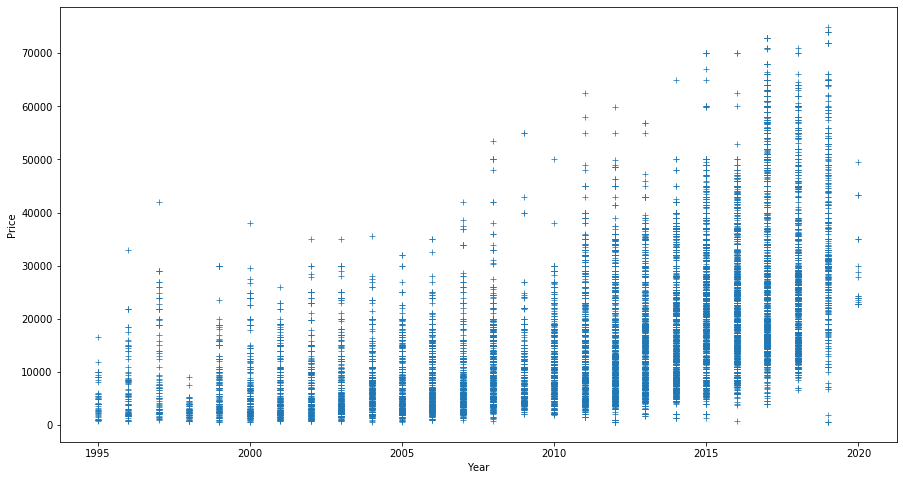

In [27]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Year',y='Price', data=vehicle,  marker= '+')
plt.show()

In [28]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'f150' : 'f-150',
                      'f250' : 'f-250', 
                      'f350' : 'f-350', 
                      'f450' : 'f-450'}
            }

vehicle.replace(model_dict, inplace=True)

#Fix Trim names.
trim_dict={'Trim': {np.nan : 'None'}}
vehicle.replace(trim_dict, inplace=True)

In [29]:
# #View any dup VINs
# pd.options.display.max_rows = 999
# vehicle.groupby(['Location','Seller','VIN']).agg({'VIN': 'count'}).nlargest(600,'VIN')

In [30]:
#Set Odometer=0 to NaN.
odZeroFilt = (vehicle['Odometer'] == 0)
zero_indices = vehicle[odZeroFilt].index
print(f'#### {len(zero_indices)} Odometer values are zero.  Set to NaN.', zero_indices)
vehicle.loc[zero_indices, 'Odometer'] = np.nan

# #Drop duplicate VINs.  60% of VINs are duplicates!
print('\n#### Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

# #Drop vehicles with duplicate Title/Odometer/Price.
print('\n#### Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

#### 34 Odometer values are zero.  Set to NaN. Int64Index([    5,     8,     9,   165,   543,  1261,  1333,  1334,  1368,
             1369,  2060,  4804,  5769,  6672,  8213,  8249, 10139, 10166,
            11027, 11434, 11435, 11555, 11580, 11581, 11584, 12452, 12838,
            13134, 13421, 16185, 16765, 17096, 18232, 18268],
           dtype='int64')

#### Duplicate VINs dropped: 3811

#### Duplicate Vehicles dropped: 2166


In [31]:
len(vehicle)

10065

In [32]:
# #Catplot by Year, Price, and Model
# sns.catplot(x='Year',y='Price',hue='Model', data=vehicle, height=10, aspect=1.3, s=9)  #s changes marker size
# plt.show()

In [33]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,displ,CombMPG,cylinders,DownFlag
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,2.0,25.0,4.0,None
2,https://austin.craigslist.org/cto/d/marble-fal...,‘04 FORD F450 SERVICE TRUCK,austin,2004,NaN,100000.0,2004 ford f450,ford,f-450,service,owner,8950.0,(Marble Falls),"\n ,\nThis is a really nice dependable ...","{'0': '<span><b>2004 FORD F450</b></span>', '1...",{'0': 'https://images.craigslist.org/01717_30H...,7022347414,None3,service,NaN,NaN,NaN,None


In [34]:
vehicle['Model'].unique()

array(['focus', 'f-450', 'e350', 'f-250', 'expedition', 'edge', 'transit',
       'f-150', 'explorer', 'f-350', 'fusion', 'e-250', 'fiesta',
       'ranger', 'e-350', 'escape', 'freestar', 'mustang', 'taurus',
       'f550', 'econoline', 'e250', 'f-550', 'five', 'e450', 'regency',
       'None', 'flex', 'c-max', 'excursion', 'crown', 'raptor', 'escort',
       '250', 'e150', 'taurua', 'mustang,', 'ecosport', 'transit-250',
       'f650', 'thunderbird', 'f-650', '350', 'windstar', 'f750',
       'f-150crewcab', 'shelby', 'escapé', 'e-150', 'e-450', 'es350',
       'sport', 'escspe', 'f1-50', 'f-350sd', 'winstar', 'buick',
       'supper', 'f-250sd', 'transit-350', 'crew', 't-350', 'scion',
       'xlt', 'cmax', 'lincoln', 'freestyle', 'f-750', 'caravan', 't350',
       'f350sd', 'contour', 'transit-150', 'expedicion', 'f800',
       'f-250hd', '2008', 'van', 'vans', 'starcraft', 'e-series', 'econo',
       '97', '5500', 'dually', 'lcf', 'f-59', 'f150-xl', 'e-350sd',
       'national', '

In [35]:
vehicle['Trim'].unique()

array(['se', 'service', 'shuttle', 'super', 'max', 'sel', 'passenger',
       'xlt', 'eddie', 'connect', '4x4', 'None', 'supercrew', 'fx2',
       'turbo', 'e-250', 'titanium', 'crew', 'tx', 'el', 'e-350',
       'lariat', 'st', 'gt', 'base', 'super crew', 'supercab', 'diesel',
       'ecoboost', 'energi', 'super duty', 'king', 'cargo', 'extended',
       'edge', 'fx4', 'xl', 'sport', 'limited', 'e450', 'dually',
       'hundred', 'box', 'e250', '7', 's', 'sd', 'platinum', '4', 'wagon',
       'fwd', 'victoria', 'pickup', 'triton', 'cutaway', 'ext', 'e350',
       '2007', 'xls', 'raptor', 'f550', 'stx', 'boss', 'convertible',
       'f350', 'f250', 'hybrid', 'mach', 'super cab', 'premium',
       'electric', 'natural', 'ltd', 'f450', 'f', 'bucket', 'econoline',
       'hightop', 'van', 'powerstroke', 'flatbed', 'v6', 'utility',
       'f650', 'outlaw', 'shelby', '15', 'deluxe', '4wd', 'lx', 'coupe',
       'gt350', 'regular', '16', 't', 'hatchback', 'flareside',
       'superduty', 'ro

### Drop missing and rare Models and Trims (Lowers Dimensionality)

In [36]:
#Remove vehicle 'Model' is None.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove vehicle 'Model' is f-350 or f-450 -- no EPA data.
filt = (vehicle['Model'] == 'f-350') | (vehicle['Model'] == 'f-450')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} Models that are "f-350" or "f-450":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove vehicle 'Trim' is None.
filt2 = (vehicle['Trim'] == 'None')
drop_indices2 = vehicle[filt2].index
print(f'Drop {len(drop_indices2)} Trims that are "None":', drop_indices2)
vehicle = vehicle.drop(index = drop_indices2, errors = 'ignore')

Drop 44 Models that are "None": Int64Index([  139,   197,   758,   966,  1526,  2417,  3003,  3188,  3388,
             4372,  5102,  5490,  5727,  6992,  7542,  7623,  7856,  8611,
             9061,  9253,  9409,  9427,  9629,  9770, 10068, 10526, 10740,
            10874, 10996, 11145, 11197, 11987, 12184, 12205, 12239, 12316,
            14405, 15087, 15289, 16065, 16263, 16329, 17634, 17827],
           dtype='int64')
Drop 817 Models that are "f-350" or "f-450": Int64Index([    2,     6,    16,    29,    72,    76,   102,   110,   126,
              133,
            ...
            17559, 17567, 17583, 17759, 17788, 17822, 17829, 17834, 17848,
            17850],
           dtype='int64', length=817)
Drop 795 Trims that are "None": Int64Index([   17,    26,    47,    67,    68,    82,   125,   128,   129,
              136,
            ...
            17720, 17728, 17744, 17764, 17768, 17771, 17780, 17855, 17859,
            17870],
           dtype='int64', length=795)


In [37]:
#Create Model_Trim feature
vehicle['Model_Trim'] = vehicle['Model'] + '_' + vehicle['Trim']

#Remove vehicle 'Model_Trim' counts under threshold.
thresh=30
trim_counts=vehicle['Model_Trim'].value_counts()             
print(f'\nDropping trim with less than {thresh} examples:\n', list(trim_counts[trim_counts < thresh].index))
trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ Model_Trim names
vehicle= vehicle[vehicle['Model_Trim'].isin(trim_over_thresh)] #boolean filter for the thresh+ Model_Trim names
print(f'\nOver {thresh} threshold trims:\n', vehicle['Model_Trim'].value_counts())


Dropping trim with less than 30 examples:
 ['fusion_sel', 'edge_limited', 'excursion_limited', 'econoline_cargo', 'escape_fwd', 'taurus_se', 'f-250_sd', 'f-150_tx', 'f-250_platinum', 'f550_4x4', 'escape_limited', 'escape_sel', 'f-150_harley', 'flex_sel', 'mustang_v6', 'mustang_shelby', 'expedition_king', 'e250_cargo', 'e350_box', 'taurus_limited', 'flex_limited', 'f-150_limited', 'fusion_energi', 'escape_xls', 'f-150_extended', 'f-150_super cab', 'c-max_hybrid', 'edge_se', 'explorer_fwd', 'f-550_super', 'five_hundred', 'f-550_f550', 'f-150_super crew', 'mustang_cobra', 'mustang_tx', 'e250_econoline', 'ranger_supercab', 'edge_titanium', 'f-150_se', 'econoline_e350', 'focus_hatchback', 'mustang_se', 'e350_van', 'ranger_edge', 'explorer_xls', 'expedition_max', 'ranger_xl', 'fiesta_st', 'transit_passenger', 'f-150_sport', 'escape_hybrid', 'focus_rs', 'f-250_fx4', 'f550_super', 'f-150_svt', 'mustang_super', 'focus_super', 'f-150_box', 'fusion_s', 'e350_cargo', 'fiesta_s', 'f550_flatbed', '

## Get train and test, stratified by Model-Trim.

In [38]:
#Build train and test from vehicle.  Stratify by Model_Trim.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
for train_index, test_index in sss.split(vehicle, vehicle['Model_Trim']):
    train = vehicle.iloc[train_index]
    test = vehicle.iloc[test_index]

In [39]:
#Drop irrelenvant columns.
irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'Make', 'SubLoc', 'Body', 'AttribDictionary', 
                    'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag']

train = train.drop(irrel_cols, axis='columns', errors='ignore')
test = test.drop(irrel_cols, axis='columns', errors='ignore')

In [40]:
#Convert categories to numbers - Target Encode features with train Price.

from category_encoders.target_encoder import TargetEncoder
encode_cols = ['Location', 'Model', 'Trim', 'Seller', 'Model_Trim']

def target_encode_categorical(train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and (2) "Prior": ExpectedVal(Target)
    over all training data.  Set testTarget to NaN to stop leakage. 
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more hyperparameters.'''
    trn=train.copy()
    tst=test.copy()
    if target in tst.columns:   #Omit any test targets from encoding.  Prevents leakage.
        tst[target] = np.nan  
    fullX = trn.append(tst)
    fullY = fullX.pop(target)       
    fullX_enc = encoder.fit_transform(fullX, fullY)
    
    #Overwrite train/test features with encoded features.  Restore test target.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    return train, test        
    
train, test = target_encode_categorical(train,test,'Price', TargetEncoder(cols=encode_cols, smoothing=0.05))

In [41]:
def multivar_impute(train, test, target):
    '''Impute values with regression on numeric columns, excluding
    the target. Returns DataFrames.'''
    
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    num_cols_ex_targ = train.select_dtypes(exclude='object').columns.tolist()
    num_cols_ex_targ.remove(target)
    
    #Get imputed dfs.
    ii = IterativeImputer(max_iter=10, random_state=3)
    train_impX = pd.DataFrame(ii.fit_transform(train[num_cols_ex_targ]), index=train.index, columns=num_cols_ex_targ)
    test_impX = pd.DataFrame(ii.transform(test[num_cols_ex_targ]), index=test.index, columns=num_cols_ex_targ)

    #Overwrite original features with imputed features.
    train[num_cols_ex_targ] = train_impX
    test[num_cols_ex_targ] = test_impX
    return train, test

train, test = multivar_impute(train, test,'Price')

In [42]:
#Fix understated odometer values.
filt_under_1K = train['Odometer'] < 1000
train.loc[filt_under_1K, 'Odometer'] = train.loc[filt_under_1K, 'Odometer'] * 1000

filt_under_1K = test['Odometer'] < 1000
test.loc[filt_under_1K, 'Odometer'] = test.loc[filt_under_1K, 'Odometer'] * 1000

#Fix overstated odometer values.
filt_over_1M = train['Odometer'] > 1_000_000
train.loc[filt_over_1M, 'Odometer'] = train.loc[filt_over_1M, 'Odometer'] / 1000

filt_over_1M = test['Odometer'] > 1_000_000
test.loc[filt_over_1M, 'Odometer'] = test.loc[filt_over_1M, 'Odometer'] / 1000

In [43]:
#Engineer features Part 2.
def get_polyfeatures(train, target, numer_cols, degree=2):
    '''
    Returns top train feature correlations as DataFrame.
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly=PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)    
    ptrn = train[numer_cols].copy()
    orig_cols = set(ptrn.columns.values)
    ptrn=pd.DataFrame(data=poly.fit_transform(ptrn),index=train.index,columns=poly.get_feature_names(input_features=numer_cols))
    final_cols = set(ptrn.columns.values)
    added_cols = final_cols - orig_cols
    print('Poly columns:', added_cols, '\n')
            
    #Get top correlation dataframe and top features list. 
    corrList = [[c, np.corrcoef(ptrn[c].values, train[target].values)[1,0]] for c in ptrn.columns]
    corrtrn=pd.DataFrame(data=corrList, columns=['feature','PriceCorr']).sort_values(by='PriceCorr', ascending=False).dropna().reset_index(drop=True)
    print('train correlations:\n\n', corrtrn)
    return ptrn[added_cols]  

num_feat=[col for col in train.select_dtypes(exclude='object').columns];
num_feat.remove('Price');

#Get poly feature dataframe.
p_added = get_polyfeatures(train=train, target='Price', numer_cols=num_feat, degree=2)

Poly columns: {'Model CombMPG', 'CombMPG cylinders', 'displ Model_Trim', 'Year CombMPG', 'Location Seller', 'Trim Model_Trim', 'CombMPG Model_Trim', 'Odometer^2', 'Year displ', 'cylinders Model_Trim', 'Location Year', 'displ cylinders', 'Model cylinders', 'Model Model_Trim', 'Trim^2', 'cylinders^2', 'Model displ', 'Model Seller', 'Odometer Trim', 'Year Model_Trim', 'Seller Model_Trim', 'CombMPG^2', 'Seller cylinders', 'Trim CombMPG', 'Model^2', 'displ^2', 'Odometer cylinders', 'Year Odometer', 'Odometer Seller', 'Trim cylinders', 'Odometer Model_Trim', 'Location CombMPG', 'Model Trim', 'Seller^2', 'Location Model', 'Odometer displ', 'Odometer Model', 'Year^2', 'Year cylinders', 'Location Odometer', 'Year Seller', 'Odometer CombMPG', 'Location^2', 'Trim displ', 'Year Trim', 'displ CombMPG', 'Location Trim', 'Seller displ', 'Location displ', 'Model_Trim^2', 'Location cylinders', 'Trim Seller', 'Year Model', 'Location Model_Trim', 'Seller CombMPG'} 

train correlations:

                 

In [44]:
train.head(2)

,Location,Year,Odometer,Model,Trim,Seller,Price,displ,CombMPG,cylinders,Model_Trim
8338,18100.933439,2012.0,106150.399148,18659.344051,16126.280899,19197.230864,20995.0,3.7,17.0,6.0,16126.280899
15021,16615.289994,2013.0,141623.000000,18659.344051,24603.294118,19197.230864,17367.0,3.7,17.0,6.0,24603.294118


In [45]:
#Part 3. Engineer pair features.

 #Squared feature.    
for elem in ['Year']:
    print(elem + '^2')
    train[elem + '^2'] = train[elem]**2
    test[elem + '^2'] = test[elem]**2

#Drop feature.    
for c in ['Location', 'Seller', 'Model_Trim']:
    train.drop(columns=c, inplace=True)
    test.drop(columns=c, inplace=True)

Year^2


In [46]:
train.head(2)

,Year,Odometer,Model,Trim,Price,displ,CombMPG,cylinders,Year^2
8338,2012.0,106150.399148,18659.344051,16126.280899,20995.0,3.7,17.0,6.0,4048144.0
15021,2013.0,141623.000000,18659.344051,24603.294118,17367.0,3.7,17.0,6.0,4052169.0


## Add knn_price base feature

In [47]:
#Helper functions

def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    from sklearn.preprocessing import RobustScaler
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

def score_algo(model, X, y, prediction):
    from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    print(' MAE:', round(mean_absolute_error(y, prediction),1))
#**************************************************************************    

#KNN -- Split out X and Y.
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

#Get One-Hot columns for the specified categ_columns.
categ_cols= trainX.select_dtypes('object').columns.values
ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX.copy(), test_df=testX.copy(), cat_cols=categ_cols)

#Drop original category columns.  Concatenate the One-Hot columns.
trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

trainX = pd.concat([trainX, ohe_train_df], axis='columns')
testX = pd.concat([testX, ohe_test_df], axis='columns')

trainX = trainX.drop(columns=['Make_ford'], axis='columns', errors='ignore')
testX = testX.drop(columns=['Make_ford'], axis='columns', errors='ignore')

#Rescale
trainXS, testXS = scale_num_df(trainX.copy(), testX.copy(), trainX.columns, RobustScaler())

#Instantiate KNN
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10)

#knn fit.  predict both train and test.
knn.fit(trainXS, trainY)

trn_pred=knn.predict(trainXS)
tst_pred=knn.predict(testXS)

#Score
score_algo(knn, trainXS, trainY, trn_pred)
score_algo(knn, testXS, testY, tst_pred)

-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3853.7
 R^2: 0.8796
 MAE: 2588.1
-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 3939.2
 R^2: 0.8743
 MAE: 2616.9


In [48]:
#Add knn_price base learner feature to train and test.
train.loc[:, 'knn_price'] = trn_pred
test.loc[:, 'knn_price'] = tst_pred

display('train:', train.head(2))
display('test:', test.head(2))

'train:'

,Year,Odometer,Model,Trim,Price,displ,CombMPG,cylinders,Year^2,knn_price
8338,2012.0,106150.399148,18659.344051,16126.280899,20995.0,3.7,17.0,6.0,4048144.0,16631.3
15021,2013.0,141623.000000,18659.344051,24603.294118,17367.0,3.7,17.0,6.0,4052169.0,18261.4


'test:'

,Year,Odometer,Model,Trim,Price,displ,CombMPG,cylinders,Year^2,knn_price
15705,2018.0,38668.0,14437.981818,14749.822222,22350.0,2.35,21.5,5.0,4072324.0,23308.5
11029,2016.0,50000.0,18659.344051,22292.090000,20000.0,3.50,18.5,6.0,4064256.0,30846.3


### Save Preprocessed data - train and test

In [49]:
#Save tables to PostgreSQL database.

import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

#Write vehicle table with json
vehicle.to_sql(name='vehicle', con=engine, if_exists='replace', index=True,\
               dtype={'AttribDictionary': JSONB, 'ImageDictionary': JSONB})

#Write train and test
train.to_sql(name='trainClean', con=engine, if_exists='replace', index=True)
test.to_sql(name='testClean', con=engine, if_exists='replace', index=True)

In [50]:
print('train shape:', train.shape, '| test shape:', test.shape)

train shape: (5580, 10) | test shape: (621, 10)


In [51]:
# #Part 3. Engineer all pair features.

# #Non-repeating pairs.
# cat_feat=('Location', 'Year', 'Odometer', 'Model', 'Trim', 'Seller', 'Model_Trim', 'displ', 'CombMPG', 'cylinders')
# pairs = list(itertools.combinations(cat_feat,2))
# for tup in pairs:
#     print(tup)    
#     train[tup[0] + '_' + tup[1]] = (train[tup[0]] * train[tup[1]])
#     test[tup[0] + '_' + tup[1]] = (test[tup[0]] * test[tup[1]])

# #Squared category feature.    
# for elem in ['Location', 'Year', 'Odometer', 'Model', 'Trim', 'Seller',
#              'Model_Trim', 'displ', 'CombMPG', 'cylinders']:
#     print(elem + '^2')
#     train[elem + '^2'] = train[elem]**2
#     test[elem + '^2'] = test[elem]**2

In [52]:
# #Populate HP.
# hp_regex=r'(\S+\s?(horse|hp|horsepower)\S+)'
# hpList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=hp_regex, no_match_value='None')    
# vehicle['hpRaw'] = hpList
# vehicle['hp']=vehicle['hpRaw'].str.extract('(\d+)').astype('float64')
# vehicle.drop(columns=['hpRaw'], inplace=True, errors='ignore')

# #Plot
# sns.distplot(vehicle['hp'].value_counts().index)
# plt.show()

# #Pivot
# vehicle.groupby(['Model_Trim'])['hp'].median()